In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mne

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Functions

def data_norm(data):
    return (data - data.min())/ (data.max() - data.min())

def get_sorted_vals(df, channels, feature='', avg_type='median'):
    """gets values of specparam feature sorted by channels in MNE object
    
    Parameters
    ----------
    df: dataframe
        dataframe of all subjects & specparam features
    channels: list
        channels in MNE object in order, will be used to determine final order of values
    feature: str
        feature of interest, must match column in df
    avg_type: str
        method to get value of avg feature for each electrode across subject, mean or median
        
    Returns
    -------
    sorted_pre_vals: 1d array
        values of desired parameter pre-treatment in the same order as MNE channels
    sorted_post_vals: same but post
        """
    
    # get values from dataframe
    if avg_type == 'mean':
        feature_array = pd.DataFrame(df.groupby(['pre_post', 'channel'], as_index=False)[feature].mean())
    elif avg_type == 'median':
        feature_array = pd.DataFrame(df.groupby(['pre_post', 'channel'], as_index=False)[feature].median())
    else:
        raise ValueError('avg_type must be mean or median')

    pre_features = feature_array[feature_array['pre_post']=='pre'][feature].values
    post_features = feature_array[feature_array['pre_post']=='post'][feature].values

    # get channels from dataframe and re-order to match MNE info object
    channels = list(feature_array[feature_array['pre_post']=='pre']['channel'].values)
    sorted_index = []

    for chan in channels:
        sorted_index.append(mne_chans.index(chan))

    sorted_pre_features = np.array([pre_features[i] for i in sorted_index])
    sorted_post_features = np.array([post_features[i] for i in sorted_index])
    
    return sorted_pre_features, sorted_post_features

In [3]:
# load dataframe
exp_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col = 0)

exp_df_included = exp_df#[exp_df['exclude']==False]

In [4]:
exp_df_included

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
0,2,pre,FP1,NaN,NaN,NaN,-12.163904,NaN,NaN,NaN,-12.963292,8.753634,1.477347,1.128229,-12.246069,-12.223400,0.544792,0.187824,0.619947,True
1,2,pre,FPZ,NaN,NaN,NaN,-11.898514,NaN,NaN,NaN,-12.804520,8.870313,1.740532,1.168099,-12.158889,-11.773319,1.047170,0.116802,0.886453,True
2,2,pre,FP2,NaN,NaN,NaN,-12.491238,NaN,NaN,NaN,-12.909546,9.179746,2.318619,1.015724,-12.133547,-12.435301,0.347079,0.102407,0.788447,True
3,2,pre,AF3,NaN,NaN,NaN,-12.397279,NaN,NaN,NaN,-12.971390,9.131372,2.397756,1.257181,-12.027771,-12.272316,0.645194,0.100321,0.892881,True
4,2,pre,AF4,NaN,NaN,NaN,-12.153451,NaN,NaN,NaN,-12.628600,8.501796,1.324216,1.118146,-11.860836,-12.160392,0.283251,0.112454,0.711893,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,55,post,PO6,2.553998,1.0,0.929427,-10.025173,5.050188,2.393840,0.906087,-10.488895,8.863919,1.844095,1.337793,-10.768737,-9.895581,1.948355,0.054988,0.995060,False
2756,55,post,PO8,2.569041,1.0,0.928161,-9.978571,5.097560,2.418158,0.944726,-10.431467,8.884905,2.130652,1.246806,-10.807347,-9.840422,1.973506,0.053256,0.995397,False
2757,55,post,O1,2.552898,1.0,0.873010,-10.044384,4.996738,2.143285,0.928408,-10.464177,8.783556,2.447756,1.084474,-10.882132,-9.898193,1.863237,0.070752,0.991415,False
2758,55,post,OZ,2.523769,1.0,0.875591,-10.084470,5.088168,2.412697,0.990874,-10.494461,8.749089,1.844382,1.053671,-11.083623,-9.911188,2.021213,0.056417,0.994520,False


In [5]:
# counts of excluded electrodes
exp_df_included.groupby(['patient', 'pre_post'])['exclude'].sum()

patient  pre_post
2        post        60
         pre         60
3        post         0
         pre          0
4        post         0
         pre          0
10       post         0
         pre          0
13       post         0
         pre          0
16       post         0
         pre          0
18       post         0
         pre          0
19       post        15
         pre         15
25       post         1
         pre          1
29       post         0
         pre          0
31       post         0
         pre          0
33       post         0
         pre          0
34       post         0
         pre          0
35       post         2
         pre          2
38       post         0
         pre          0
39       post         0
         pre          0
40       post         0
         pre          0
47       post         0
         pre          0
48       post         0
         pre          0
50       post        13
         pre         13
53       post         

### Get MNE info object for electrode positions

In [6]:
eeg_data_path = '/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT002_POST_REST_EC.fif'

eeg_data = mne.io.read_raw(eeg_data_path)

Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT002_POST_REST_EC.fif...
    Range : 0 ... 649199 =      0.000 ...   649.199 secs
Ready.


In [7]:
eeg_data = eeg_data.pick_types(eeg=True)

In [8]:
mne_chans = eeg_data.info['ch_names']

# R$^{2}$

get topology of model fits -- are there any electrodes that are particularly bad across subjects that should be dropped across the whole dataset?

In [9]:
sorted_pre_r2s, sorted_post_r2s = get_sorted_vals(exp_df_included, mne_chans, feature='r_squared', avg_type='mean')
diff = sorted_post_r2s - sorted_pre_r2s

Text(0.5, 1.0, 'post model fit R$^{2}$')

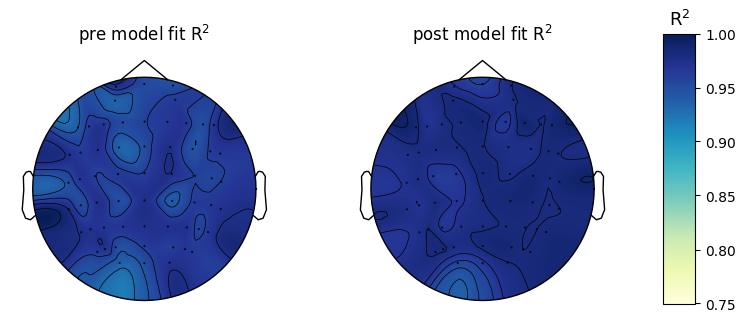

In [10]:
unit_label = 'R$^{2}$'
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=[8,3])
im, cm = mne.viz.plot_topomap(sorted_pre_r2s, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0.75, vmax=1.0, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(sorted_post_r2s, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0.75, vmax=1.0, cmap='YlGnBu')

# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre model fit R$^{2}$')
ax2.set_title('post model fit R$^{2}$')

# plot R2 across all subjects

average model fit plots aren't really working for me... let's see if there are consistently bad electrodes by plotting all subjects topoplots

Text(0.5, 1.0, 'R$^{2}$')

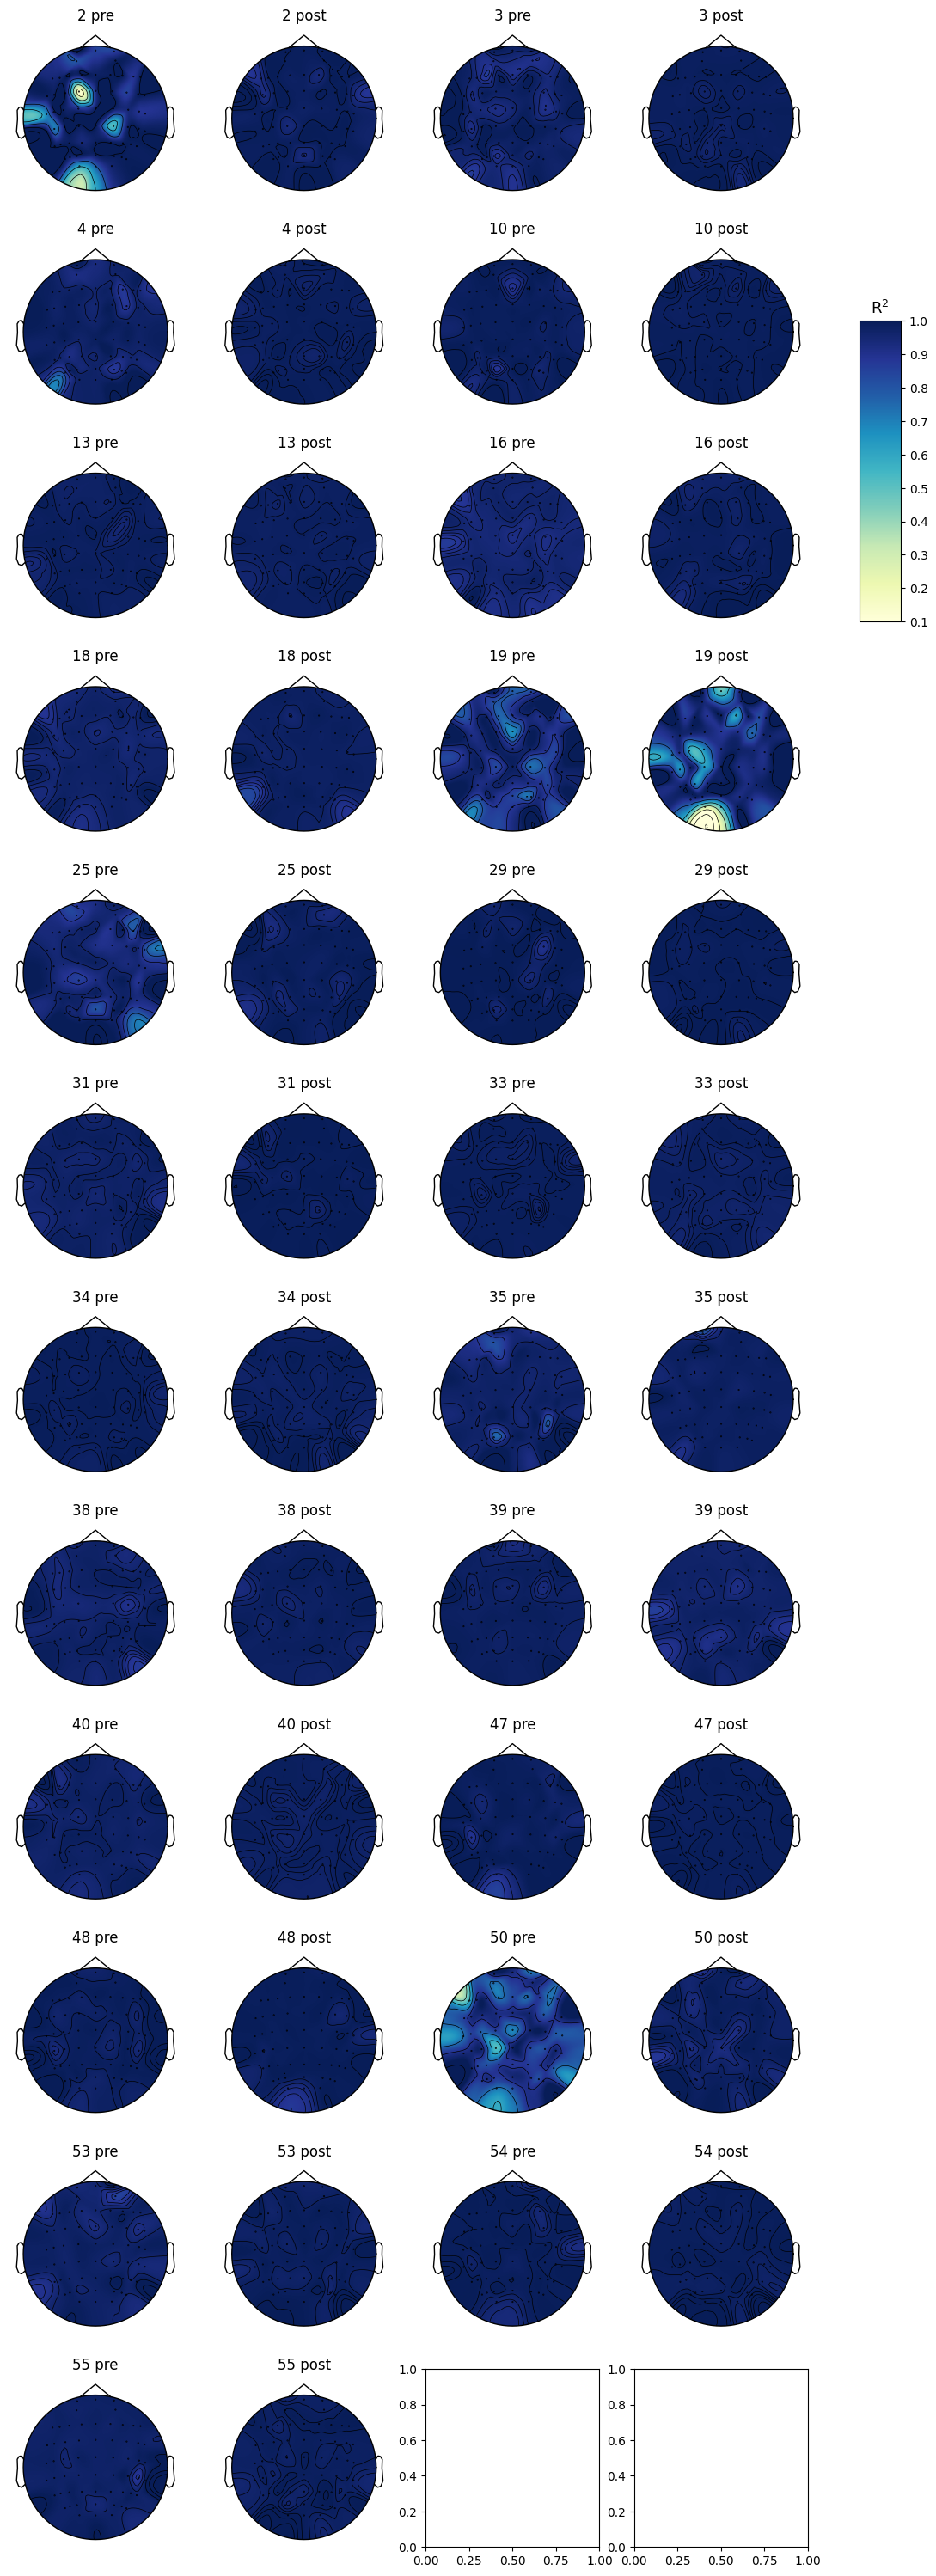

In [11]:
unit_label = 'R$^{2}$'

patients = exp_df_included['patient'].unique()

fig,axs = plt.subplots(12,4, figsize=[12,35])
axs = axs.ravel()

ind = 0

for patient in patients:
    df = exp_df_included[exp_df_included['patient']==patient]
    
    sorted_pre_r2s, sorted_post_r2s = get_sorted_vals(df, mne_chans, feature='r_squared',
                                                      avg_type='mean')
    
    im, cm = mne.viz.plot_topomap(sorted_pre_r2s, axes=axs[ind], pos=eeg_data.info, show=False,
                              vmin=0.1, vmax=1.0, cmap='YlGnBu')
    axs[ind].set_title(str(patient)+' pre')
    ind +=1 
    
    im, cm = mne.viz.plot_topomap(sorted_post_r2s, axes=axs[ind], pos=eeg_data.info, show=False,
                              vmin=0.1, vmax=1.0, cmap='YlGnBu')
    axs[ind].set_title(str(patient)+' post')
    ind +=1

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.75
ax_y_height = 0.1
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13)

# Delta

In [12]:
sorted_pre_delta_amps, sorted_post_delta_amps = get_sorted_vals(exp_df_included, mne_chans,
                                                                feature='delta_amp', avg_type='median')
    
sorted_pre_delta_amps = np.nan_to_num(sorted_pre_delta_amps, nan=0.05) # replace no delta peak channels with absolute threshold
sorted_post_delta_amps = np.nan_to_num(sorted_post_delta_amps, nan=0.05) # replace no delta peak channels with abs threshold

diff = sorted_post_delta_amps - sorted_pre_delta_amps


Text(0.5, 1.0, 'delta peak amplitude difference')

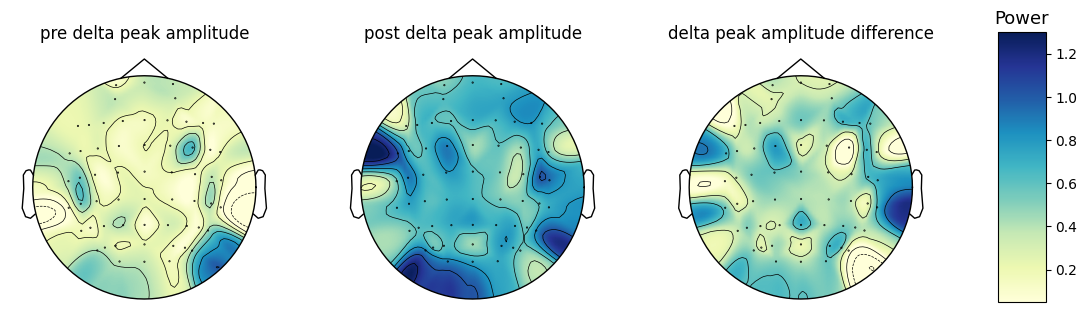

In [13]:
unit_label = 'Power'
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=[12,3])
im, cm = mne.viz.plot_topomap(sorted_pre_delta_amps, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.3, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(sorted_post_delta_amps, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.3, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(diff, axes=ax3, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.3, cmap='YlGnBu')

# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre delta peak amplitude')
ax2.set_title('post delta peak amplitude')
ax3.set_title('delta peak amplitude difference')

# Theta

In [14]:
sorted_pre_theta_amps, sorted_post_theta_amps = get_sorted_vals(exp_df_included, mne_chans,
                                                                feature='theta_amp', avg_type='median')
    
sorted_pre_theta_amps = np.nan_to_num(sorted_pre_theta_amps, nan=0.05) # replace no theta peak channels with absolute threshold
sorted_post_theta_amps = np.nan_to_num(sorted_post_theta_amps, nan=0.05) # replace no theta peak channels with abs threshold

diff = sorted_post_theta_amps - sorted_pre_theta_amps
                                                                

Text(0.5, 1.0, 'theta peak amplitude difference')

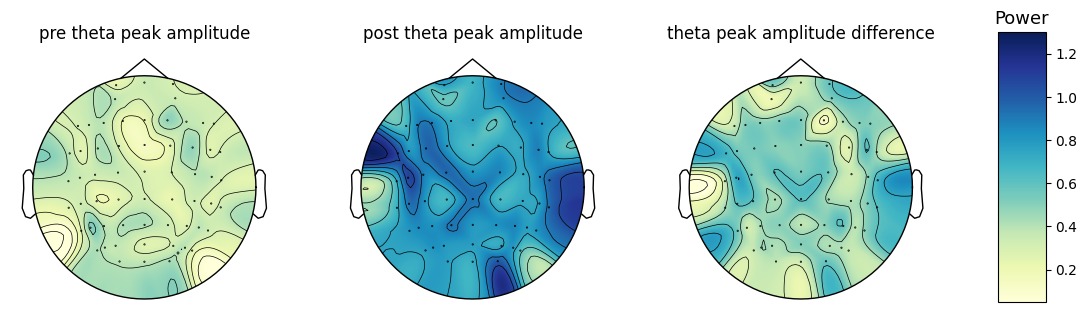

In [15]:
unit_label = 'Power'
fig,(ax1,ax2, ax3) = plt.subplots(ncols=3, figsize=[12,3])
im, cm = mne.viz.plot_topomap(sorted_pre_theta_amps, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.3, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(sorted_post_theta_amps, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.3, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(diff, axes=ax3, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.3, cmap='YlGnBu')

# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre theta peak amplitude')
ax2.set_title('post theta peak amplitude')
ax3.set_title('theta peak amplitude difference')

# Exponent

In [16]:
sorted_pre_exponents, sorted_post_exponents = get_sorted_vals(exp_df_included, mne_chans,
                                                              feature='exponent', avg_type='median')
diff = sorted_post_exponents - sorted_pre_exponents

Text(0.5, 1.0, 'exponent difference')

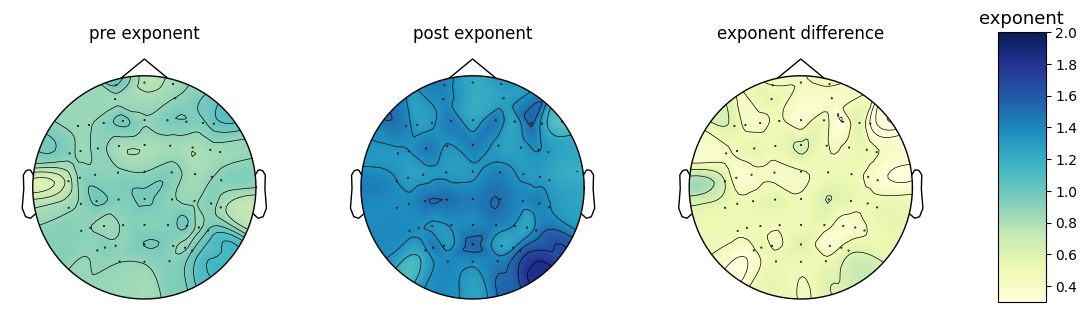

In [17]:
unit_label = 'exponent'
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=[12,3])
im, cm = mne.viz.plot_topomap(sorted_pre_exponents, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0.3, vmax=2.0, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(sorted_post_exponents, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0.3, vmax=2.0, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(diff, axes=ax3, pos=eeg_data.info, show=False,
                              vmin=0.3, vmax=2.0, cmap='YlGnBu')

# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre exponent')
ax2.set_title('post exponent')
ax3.set_title('exponent difference')

# Delta Band Power

In [18]:
sorted_pre_delta_bp, sorted_post_delta_bp  = get_sorted_vals(exp_df_included, mne_chans,
                                                             feature='delta_bp', avg_type='median')

diff = sorted_post_delta_bp - sorted_pre_delta_bp

In [19]:
# normalize band powers
all_bp = np.concatenate([sorted_pre_delta_bp, sorted_post_delta_bp])
norm_all = data_norm(all_bp)
norm_pre = norm_all[:60]
norm_post = norm_all[60:]
diff = norm_post-norm_pre

Text(0.5, 1.0, 'delta band power difference')

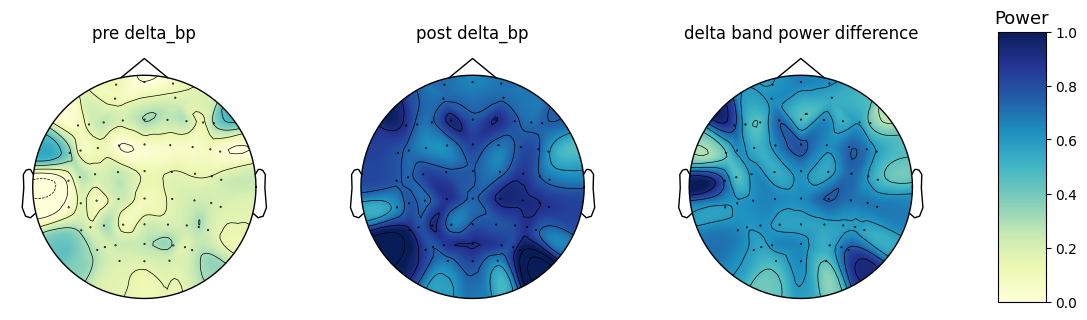

In [20]:
unit_label = 'Power'
fig,(ax1,ax2, ax3) = plt.subplots(ncols=3, figsize=[12,3])
im, cm = mne.viz.plot_topomap(norm_pre, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0., vmax=1., cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(norm_post, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0., vmax=1., cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(diff, axes=ax3, pos=eeg_data.info, show=False,
                              vmin=0., vmax=1., cmap='YlGnBu')
# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre delta_bp')
ax2.set_title('post delta_bp')
ax3.set_title('delta band power difference')